
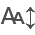

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)

In [2]:
df = pd.read_excel('who_aap_2021_v9_11august2022.xlsx', sheet_name='AAP_2022_city_v9')
df.head()

WHO Region ISO3 WHO Country Name City or Locality  \
0  Eastern Mediterranean Region  AFG      Afghanistan            Kabul   
1               European Region  ALB          Albania           Durres   
2               European Region  ALB          Albania           Durres   
3               European Region  ALB          Albania          Elbasan   
4               European Region  ALB          Albania          Elbasan   

   Measurement Year  PM2.5 (μg/m3)  PM10 (μg/m3)  NO2 (μg/m3)  \
0              2019         119.77           NaN          NaN   
1              2015            NaN         17.65        26.63   
2              2016          14.32         24.56        24.78   
3              2015            NaN           NaN        23.96   
4              2016            NaN           NaN        26.26   

   PM25 temporal coverage (%)  PM10 temporal coverage (%)  \
0                        18.0                         NaN   
1                         NaN                         NaN   
2                         NaN                         NaN   
3                         NaN                         NaN   
4                         NaN                         NaN   

   NO2 temporal coverage (%)  \
0                        NaN   
1                  83.961187   
2                  87.932605   
3                  97.853881   
4                  96.049636   

                                           Reference  \
0  U.S. Department of State, United States Enviro...   
1   European Environment Agency (downloaded in 2021)   
2   European Environment Agency (downloaded in 2021)   
3   European Environment Agency (downloaded in 2021)   
4   European Environment Agency (downloaded in 2021)   

  Number and type of monitoring stations  Version of the database  Status  
0                                    NaN                     2022     NaN  
1                                    NaN                     2022     NaN  
2                                    NaN                     2022     NaN  
3                                    NaN                     2022     NaN  
4                                    NaN                     2022     NaN

In [3]:
missing_data = pd.DataFrame({
    'Missing Values': df.isna().sum(),
    'Percentage':round((df.isna().sum() / len(df)) * 100, 2)
})
missing_data

Missing Values  Percentage
WHO Region                                           1        0.00
ISO3                                                 0        0.00
WHO Country Name                                     0        0.00
City or Locality                                     0        0.00
Measurement Year                                     0        0.00
PM2.5 (μg/m3)                                    17143       53.25
PM10 (μg/m3)                                     11082       34.43
NO2 (μg/m3)                                       9991       31.04
PM25 temporal coverage (%)                       24916       77.40
PM10 temporal coverage (%)                       26810       83.28
NO2 temporal coverage (%)                        12301       38.21
Reference                                            5        0.02
Number and type of monitoring stations           23433       72.79
Version of the database                              0        0.00
Status                                           32191      100.00

Kolumna 'Status' nie zawiera żadnych danych, więc zostanie usunięta. 

Kolumny 'Reference', 'Number and type of monitoring stations' oraz 'Version of the database' nie wnoszą żadnych istotnych informacji do analizy, dlatego również zostaną usunięte.

Kolumnę 'ISO3' również można usunąć, gdyż jest to kod odpowiadający konkretnej nazwie państwa, co jest już zawarte w kolumnie 'WHO Country Name'

In [4]:
df = df.drop(columns=['Status', 'Reference', 'Number and type of monitoring stations', 'Version of the database', 'ISO3'])
df.head(10)

WHO Region WHO Country Name City or Locality  \
0  Eastern Mediterranean Region      Afghanistan            Kabul   
1               European Region          Albania           Durres   
2               European Region          Albania           Durres   
3               European Region          Albania          Elbasan   
4               European Region          Albania          Elbasan   
5               European Region          Albania          Elbasan   
6               European Region          Albania            Korce   
7               European Region          Albania            Korce   
8               European Region          Albania            Vlore   
9               European Region          Albania            Vlore   

   Measurement Year  PM2.5 (μg/m3)  PM10 (μg/m3)  NO2 (μg/m3)  \
0              2019         119.77           NaN          NaN   
1              2015            NaN         17.65        26.63   
2              2016          14.32         24.56        24.78   
3              2015            NaN           NaN        23.96   
4              2016            NaN           NaN        26.26   
5              2017            NaN           NaN        24.70   
6              2015          30.34         45.31          NaN   
7              2016          28.64         40.21        12.52   
8              2014            NaN         15.25          NaN   
9              2015            NaN         19.39        14.18   

   PM25 temporal coverage (%)  PM10 temporal coverage (%)  \
0                        18.0                         NaN   
1                         NaN                         NaN   
2                         NaN                         NaN   
3                         NaN                         NaN   
4                         NaN                         NaN   
5                         NaN                         NaN   
6                         NaN                         NaN   
7                         NaN                         NaN   
8                         NaN                         NaN   
9                         NaN                         NaN   

   NO2 temporal coverage (%)  
0                        NaN  
1                  83.961187  
2                  87.932605  
3                  97.853881  
4                  96.049636  
5                  89.292237  
6                        NaN  
7                  89.287341  
8                        NaN  
9                  78.470320

Analizowane głównie dalej będą zmienne 'PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)', które stanowią główne miary oceny jakości powietrza będącego celem tej analizy. Zmienne "temporal coverage" są niejako zmiennymi pomocniczymi i stanowią informacje o czasowym pokryciu danych dla konkretnego rodzaju zanieczyszczenia.

W zbiorze danych występuję bardzo duża ilość brakujących danych dla danych PM2.5 wartość wynosi aż 53.25%, natomiast dla danych PM10 oraz NO2 to odpowiednio 34% i 31%.

Można przypuszczać, że brak danej wartości w zbiorze będzie zależeć od tego w jakim Mieście/Kraju/Regionie znajduje się dana stacja pomiarowa. Aby to sprawdzić zostanie policzona wartość współczynnika V Cramera przy założeniu, że występowanie braków danych jest powiązane z lokalizacją stacji. Im wyższa wartość współczynnika V Cramera, tym silniejszy związek pomiędzy lokalizacją a brakami danych.

In [5]:
print(f"Ilość unikalnych regionów: {df['WHO Region'].nunique()}")
print(f"Ilość unikalnych państw: {df['WHO Country Name'].nunique()}")
print(f"Ilość unikalnych miast: {df['City or Locality'].nunique()}")


Ilość unikalnych regionów: 6
Ilość unikalnych państw: 118
Ilość unikalnych miast: 6874


In [6]:
from scipy.stats import chi2_contingency

columns_to_check = ['PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)']

for col in columns_to_check:
    df[f"{col}_missing"] = df[col].isnull()

# City or Locality
results_city = []
for col in columns_to_check:
    missing_col = f"{col}_missing"
    contingency_table = pd.crosstab(df['City or Locality'], df[missing_col])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
    results_city.append({
        'Variable': col,
        'Chi2 Statistic': chi2,
        'p-value': p,
        "Cramer's V": cramers_v
    })
city_results_df = pd.DataFrame(results_city)
print("City or Locality")
display(city_results_df.head(3))

# WHO Country Name
results_country = []
for col in columns_to_check:
    missing_col = f"{col}_missing"
    contingency_table = pd.crosstab(df['WHO Country Name'], df[missing_col])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
    results_country.append({
        'Variable': col,
        'Chi2 Statistic': chi2,
        'p-value': p,
        "Cramer's V": cramers_v
    })
country_results_df = pd.DataFrame(results_country)
print("WHO Country Name")
display(country_results_df)

# WHO Region
results_region = []
for col in columns_to_check:
    missing_col = f"{col}_missing"
    contingency_table = pd.crosstab(df['WHO Region'], df[missing_col])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
    results_region.append({
        'Variable': col,
        'Chi2 Statistic': chi2,
        'p-value': p,
        "Cramer's V": cramers_v
    })
region_results_df = pd.DataFrame(results_region)
print("WHO Region")
display(region_results_df)

City or Locality


Variable  Chi2 Statistic  p-value  Cramer's V
0  PM2.5 (μg/m3)    26038.260074      0.0    0.899371
1   PM10 (μg/m3)    25554.238627      0.0    0.890972
2    NO2 (μg/m3)    26213.312589      0.0    0.902389

WHO Country Name


Variable  Chi2 Statistic  p-value  Cramer's V
0  PM2.5 (μg/m3)     9285.831080      0.0    0.537085
1   PM10 (μg/m3)    12748.633534      0.0    0.629310
2    NO2 (μg/m3)    14629.655940      0.0    0.674140

WHO Region


Variable  Chi2 Statistic  p-value  Cramer's V
0  PM2.5 (μg/m3)     5466.850133      0.0    0.412105
1   PM10 (μg/m3)     7708.013528      0.0    0.489340
2    NO2 (μg/m3)    10163.191856      0.0    0.561894

Współczynnik V Cramera osiąga najwyższe wartości dla różnych miast, gdzie dla wszystkich trzech zmiennych przekracza 0.89, na poziomie kraju od ok. 0.54 do 0.67 a w przypadku regionu od ok. 0.41 do 0.56. Wszystkie wartości p-value są równe 0, co oznacza, że zależności są statystycznie istotne.

Braki danych w analizowanych zmiennych są w dużym stopniu zależne od lokalizacji, najbardziej na poziomie miasta a najmniej na poziomie regionu. Wynika to z większej granulacji obszarów i łączenia ze sobą wielu miast w 1 obszar i uśredniania tychże wyników.

Takie wyniki świadczą o tym, że braki należy zaklasyfikować jako MAR, ponieważ zależą one od wielu innych czynników.

Text(0.5, 1.0, 'Histogram of Missing Percentage')

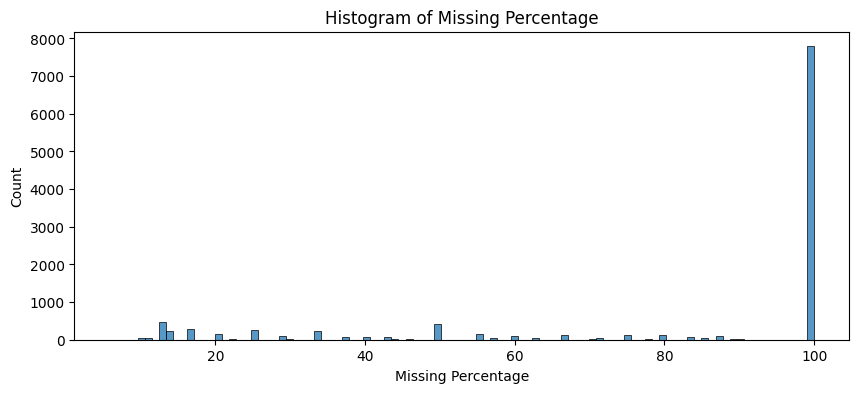

In [7]:
missing_by_city = df.groupby('City or Locality')[columns_to_check].apply(lambda x: x.isnull().sum())
counts_by_city = df.groupby('City or Locality')[columns_to_check].count()

missing_by_city = missing_by_city.reset_index()
counts_by_city = counts_by_city.reset_index()

missing_by_city.columns = ['City or Locality'] + columns_to_check
counts_by_city.columns = ['City or Locality'] + [col + '_count' for col in columns_to_check]

merged = pd.merge(missing_by_city, counts_by_city, on='City or Locality')

merged = merged.rename(columns={
    'PM2.5 (μg/m3)': 'PM2.5_missing',
    'PM10 (μg/m3)': 'PM10_missing',
    'NO2 (μg/m3)': 'NO2_missing',
    'PM2.5 (μg/m3)_count': 'PM2.5_count',
    'PM10 (μg/m3)_count': 'PM10_count',
    'NO2 (μg/m3)_count': 'NO2_count'
})

missing_long = merged.melt(
    id_vars='City or Locality',
    value_vars=['PM2.5_missing', 'PM10_missing', 'NO2_missing'],
    var_name='Pollutant',
    value_name='Missing Values'
)

count_long = merged.melt(
    id_vars='City or Locality',
    value_vars=['PM2.5_count', 'PM10_count', 'NO2_count'],
    var_name='Pollutant_count',
    value_name='Total Measurements'
)

missing_long['Pollutant'] = missing_long['Pollutant'].str.replace('_missing', '')
count_long['Pollutant'] = count_long['Pollutant_count'].str.replace('_count', '')

final = pd.merge(
    missing_long[['City or Locality', 'Pollutant', 'Missing Values']],
    count_long[['City or Locality', 'Pollutant', 'Total Measurements']],
    on=['City or Locality', 'Pollutant']
)

final['Missing Values'] = final['Missing Values'].astype(int)
final['Total Measurements'] = final['Total Measurements'].astype(int)
final['Missing Percentage'] = (final['Missing Values'] / (final['Missing Values'] + final['Total Measurements'])) * 100
final['Missing Percentage'] = final['Missing Percentage'].round(2)

final = final[final['Missing Values'] > 0]

plt.figure(figsize=(10, 4))
sns.histplot(final['Missing Percentage'], bins = 100)
plt.title('Histogram of Missing Percentage')

Imputacja w miastach z 100% brakami nie ma sensu, ponieważ nie ma żadnych danych, na podstawie których można by uzupełnić wartości. Mogłaby ona mieć sens dla danych, które mają np mniej niż 10% braków, jednak takich przypadków jest bardzo mało. 

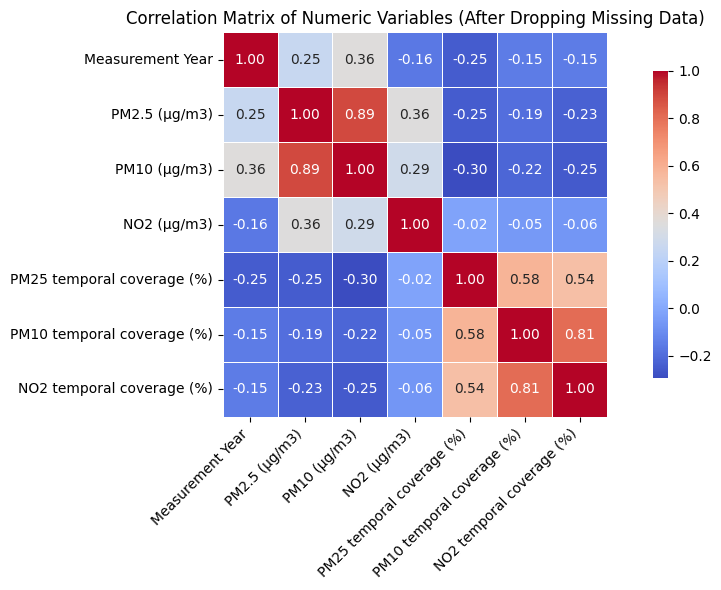

In [8]:
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
df_cleaned = df.dropna(subset=numeric_columns)

correlation_matrix = df_cleaned[numeric_columns].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, linewidths=0.5)
plt.title('Correlation Matrix of Numeric Variables (After Dropping Missing Data)')
_ = plt.xticks(rotation=45, ha='right')
plt.tight_layout()

Zanieczyszczenia PM2.5 są silnie powiązane z PM10 z racji, że cząstki PM2.5 zaliczają się do cząstek PM10. Korelacja pyłów PM z NO2 jest mniejsza z racji, że jest to inny typ zanieczyszczeń o innych właściwościach, jednak dość często jego obecność jest powiązana z pyłami PM.

# Analiza według regionu

In [9]:
grouped_region = df.groupby('WHO Region').agg({
    'PM2.5 (μg/m3)': ['mean', 'std'],
    'PM10 (μg/m3)': ['mean', 'std'],
    'NO2 (μg/m3)': ['mean', 'std']
}).reset_index()

grouped_region.columns = ['WHO Region', 'PM2.5 Mean', 'PM2.5 Std',
                          'PM10 Mean', 'PM10 Std',
                          'NO2 Mean', 'NO2 Std']

grouped_region = grouped_region.sort_values(by='PM2.5 Mean', ascending=False)
grouped_region.reset_index(drop=True, inplace=True)

grouped_region

WHO Region  PM2.5 Mean  PM2.5 Std   PM10 Mean   PM10 Std  \
0        South East Asia Region   42.841212  23.432654   94.626582  51.400386   
1        Western Pacific Region   40.324123  18.012102   32.781478  27.102957   
2  Eastern Mediterranean Region   38.063258  19.843202  121.317951  76.441168   
3                African Region   27.257120  20.435911   51.906625  38.927441   
4               European Region   14.002193   6.315753   23.014195  10.934612   
5        Region of the Americas   11.389410   8.387063   30.677423  18.969999   

    NO2 Mean    NO2 Std  
0  22.099986  12.845567  
1  31.970357  14.094483  
2  45.715101  29.840508  
3  23.160242  15.597572  
4  20.388851  11.319905  
5  15.757890  10.055134

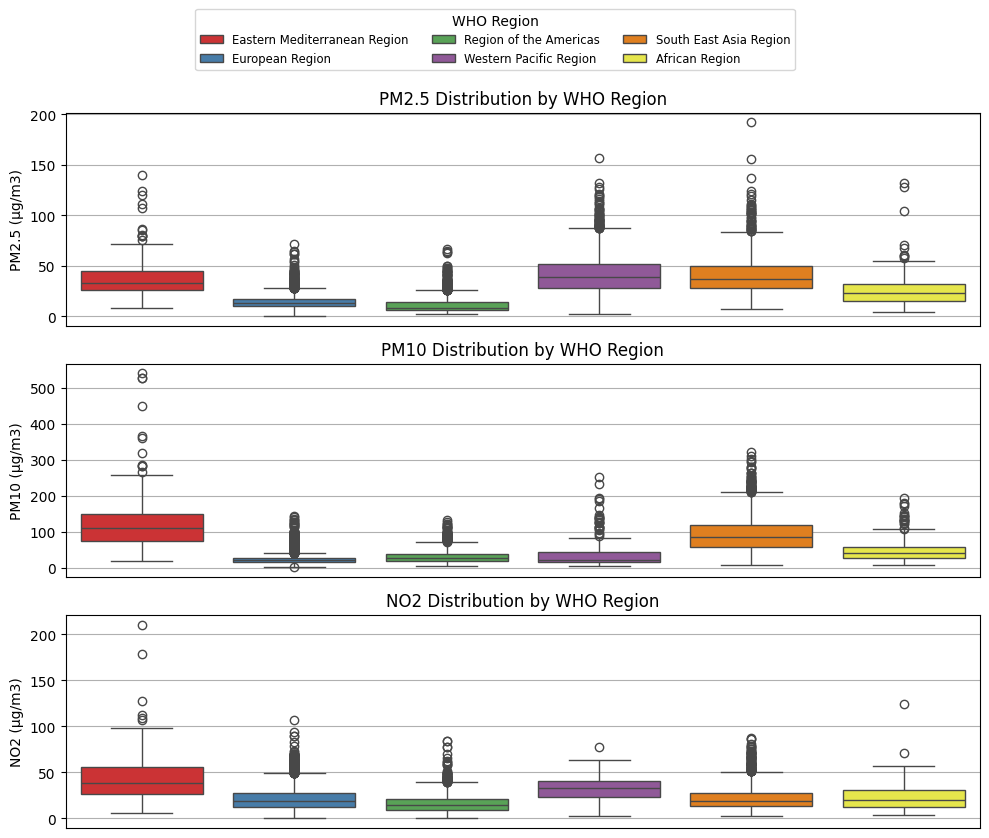

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)


sns.boxplot(data=df, x='WHO Region', y='PM2.5 (μg/m3)', ax=axes[0], hue='WHO Region', palette="Set1")
axes[0].set_title('PM2.5 Distribution by WHO Region')
axes[0].set_ylabel('PM2.5 (μg/m3)')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', bottom=False, labelbottom=False)
axes[0].legend_.remove()
axes[0].yaxis.grid(True)

sns.boxplot(data=df, x='WHO Region', y='PM10 (μg/m3)', ax=axes[1], hue='WHO Region', palette="Set1")
axes[1].set_title('PM10 Distribution by WHO Region')
axes[1].set_ylabel('PM10 (μg/m3)')
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', bottom=False, labelbottom=False)
axes[1].legend_.remove()
axes[1].yaxis.grid(True)

sns.boxplot(data=df, x='WHO Region', y='NO2 (μg/m3)', ax=axes[2], hue='WHO Region', palette="Set1")
axes[2].set_title('NO2 Distribution by WHO Region')
axes[2].set_ylabel('NO2 (μg/m3)')
axes[2].set_xlabel('')
axes[2].tick_params(axis='x', bottom=False, labelbottom=False)
axes[2].legend_.remove()
axes[2].yaxis.grid(True)

handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, title='WHO Region', loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fontsize='small')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the legend
plt.show()

Regiony Europy i Ameryk mają naniższe mediany i rozrzuty, co świadczy o lepszej jakości powietrza w tych regionach. Z kolei Region bliskiego wschodu oraz Południowo wschodniej Azji mają najwyższe mediany i szeroki rozrzut wartości co wskazuje na problem z jakością powietrza w tym regionie. Zróżnicowanie rozkładów między regionami może wynikać z wielu czynników m.in.: różnic w uprzemysłowieniu, urbanizacji, polityce środowiskowej i warunkach geograficznych. Ponadto w każdym regionie wyraźnie widoczne są wartości odstające, co świadczy o zróżnicowaniu w regionach i o tym, że taki poziom dokładności analizy może być niedokładny.

# Analiza według kraju

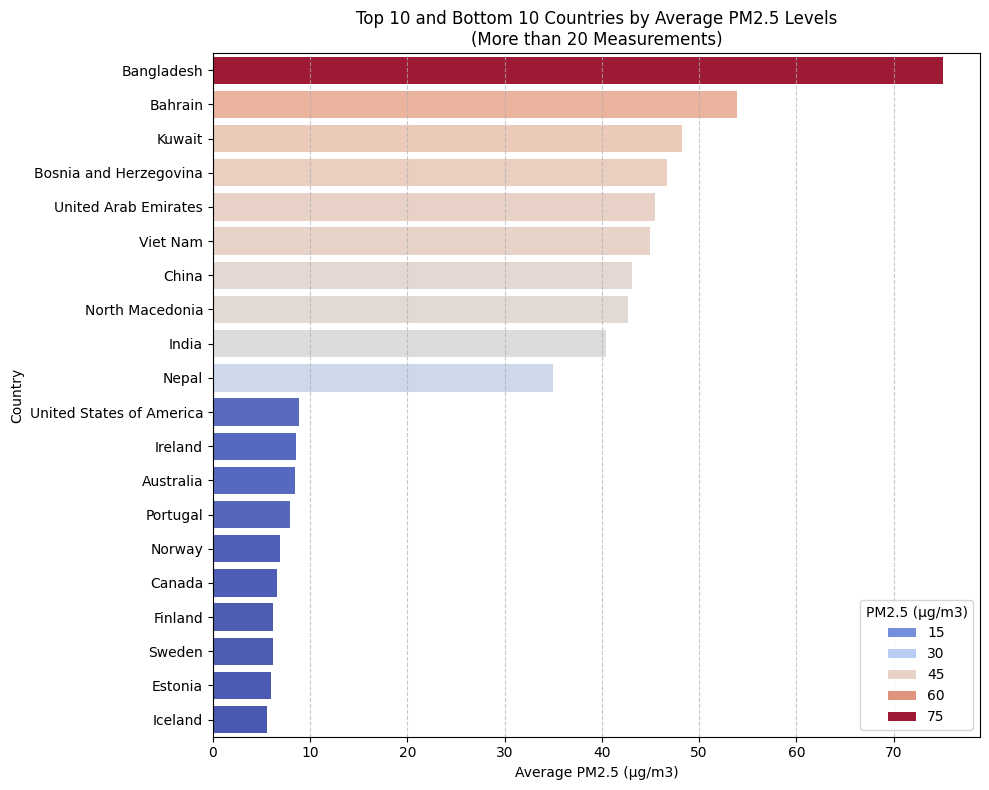

In [11]:
country_counts = df['WHO Country Name'].value_counts()

min_measurements = 20
valid_countries = country_counts[country_counts > min_measurements].index
filtered_df = df[df['WHO Country Name'].isin(valid_countries)]

country_pm25_mean = filtered_df.groupby('WHO Country Name')['PM2.5 (μg/m3)'].mean()
top10 = country_pm25_mean.nlargest(10)
bottom10 = country_pm25_mean.nsmallest(10)
top_bottom = pd.concat([top10, bottom10]).reset_index()

top_bottom = top_bottom.sort_values(by='PM2.5 (μg/m3)', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 8))
sns.barplot(
    data=top_bottom, 
    x='PM2.5 (μg/m3)', 
    y='WHO Country Name', 
    hue='PM2.5 (μg/m3)',
    palette='coolwarm',
)
plt.title(f'Top 10 and Bottom 10 Countries by Average PM2.5 Levels\n(More than {min_measurements} Measurements)')
plt.xlabel('Average PM2.5 (μg/m3)')
plt.ylabel('Country')
#add vertical grid lines
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Kraje z najwyższymi wartościami PM2.5 to głównie państwa Azji Południowej i Bliskiego Wschodu, a z najniższymi to kraje Europy oraz Australia i USA, co było widoczne już na wcześniejszym wykresie.

Różnice między najwyższymi a najniższymi wartościami PM2.5 są bardzo wyraźne, różnice wartości są kilkukrotne. Jakość powietrza jest bardzo zależna od lokalnych warunków.

Z racji na bardzo dużą ilość unikalnych krajów w zbiorze danych (118) konieczne jest pominięcie części wyświetlanych krajów, ponieważ tworzą one zbyt dużo kategorii.

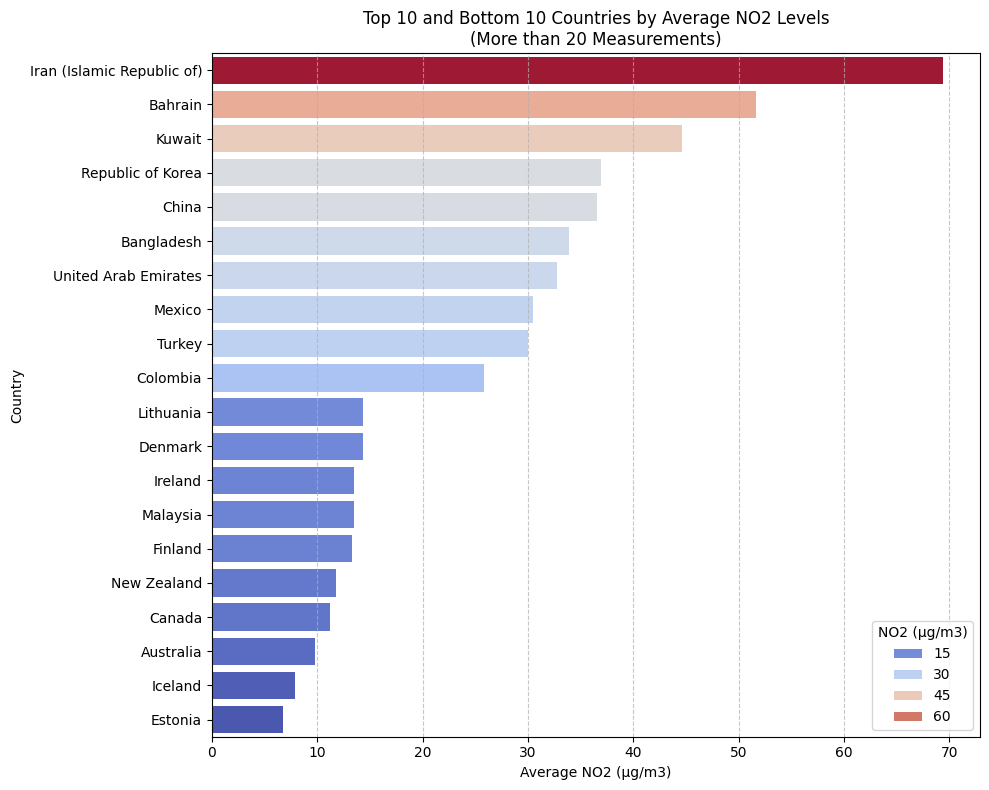

In [12]:
country_counts = df['WHO Country Name'].value_counts()

min_measurements = 20
valid_countries = country_counts[country_counts > min_measurements].index
filtered_df = df[df['WHO Country Name'].isin(valid_countries)]

country_no2_mean = filtered_df.groupby('WHO Country Name')['NO2 (μg/m3)'].mean()
top10_no2 = country_no2_mean.nlargest(10)
bottom10_no2 = country_no2_mean.nsmallest(10)
top_bottom_no2 = pd.concat([top10_no2, bottom10_no2]).reset_index()

top_bottom_no2 = top_bottom_no2.sort_values(by='NO2 (μg/m3)', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 8))
sns.barplot(
    data=top_bottom_no2, 
    x='NO2 (μg/m3)', 
    y='WHO Country Name', 
    hue='NO2 (μg/m3)',
    palette='coolwarm',
)
plt.title(f'Top 10 and Bottom 10 Countries by Average NO2 Levels\n(More than {min_measurements} Measurements)')
plt.xlabel('Average NO2 (μg/m3)')
plt.ylabel('Country')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

W krajach takich jak Bangladesz, Bahrajn, Kuwejt, Chiny czy Zjednoczone Emiraty Arabskie obserwujemy wysokie wskaźniki zarówno pyłów PM2.5 jak i gazów NO2. Są to kraje z wysokim poziomem urbanizacji, dużym zużycie paliw kopalnych, oraz wysokim poziomem emisji z transportu i przemysłu.

Kraje takie jak Indie, Nepal, Wietnam, Macedonia Północna, Bośnia i Hercegowina posiadają wysoki wskaźnik PM2.5, jednak nie ma ich w rankingu dla NO2 co może być spowodane tym, że źródłem zanieczyszczenia w tych krajach jest spalanie niskiej jakość paliw, a nie emisje NO2, których głownym źródłem jest transport.

W krajach takich jak Iran, Korea Południowa, Meksyk, Turcja, Kolumbia obserwujemy bardzo wysokie wartości NO2, natomiast zanieczyszczenia pyłami PM2.5 są relatywnie niższe niż w innych krajach. W tych krajach głównym źródłem zanieczyczszceń jest ruch drogowy (NO2 powstaje głównie w wyniku spalania paliw w wysokich temperaturach - silniki spalinowe).

# Analiza według miasta

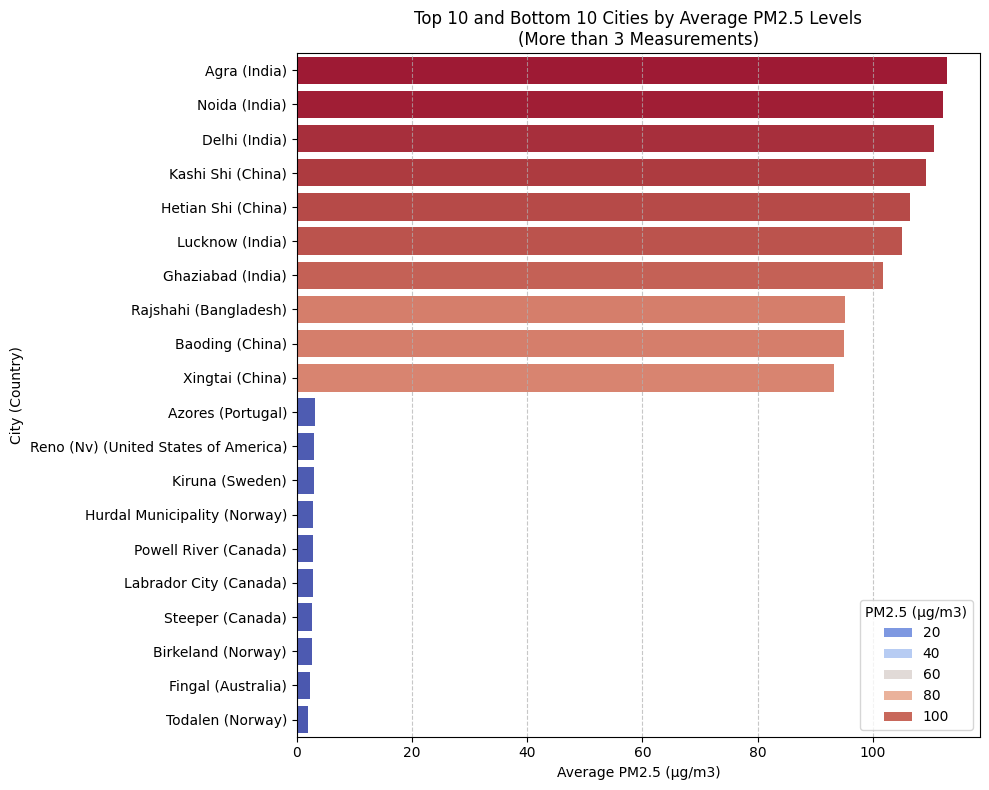

In [13]:
city_counts = df['City or Locality'].value_counts()

min_measurements_city = 3
valid_cities = city_counts[city_counts > min_measurements_city].index
filtered_city_df = df[df['City or Locality'].isin(valid_cities)].copy()

filtered_city_df['City_Country'] = filtered_city_df['City or Locality'] + " (" + filtered_city_df['WHO Country Name'] + ")"

city_pm25_mean = filtered_city_df.groupby('City_Country')['PM2.5 (μg/m3)'].mean()
top10_cities = city_pm25_mean.nlargest(10)
bottom10_cities = city_pm25_mean.nsmallest(10)
top_bottom_cities = pd.concat([top10_cities, bottom10_cities]).reset_index()

top_bottom_cities = top_bottom_cities.sort_values(by='PM2.5 (μg/m3)', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 8))
sns.barplot(
    data=top_bottom_cities, 
    x='PM2.5 (μg/m3)', 
    y='City_Country', 
    hue='PM2.5 (μg/m3)',
    palette='coolwarm',
)
plt.title(f'Top 10 and Bottom 10 Cities by Average PM2.5 Levels\n(More than {min_measurements_city} Measurements)')
plt.xlabel('Average PM2.5 (μg/m3)')
plt.ylabel('City (Country)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Najwyższe wartości PM2.5 obserwowane są w miastach położonych głównie w Indiach oraz w Chinach, a także w Bangladeszu. Średnie stężenia w tych miastach przekraczają 90 ug/m3, co znacznie przewyższa zalecenia WHO (5ug/m3 - średnia roczna) i świadczy o bardzo złej jakości powietrza. Wysokie wartości mogą być związane z bardzo dużą gęstością zaludnienia, intensywnym ruchem drogowym.

Z kolei najniższe wartości PM2.5 notowane są w miastach położonych w Norwegii, Kanadzie, Australii, Portugalii, Szwecji oraz w Stanach Zjednoczonych. W tych lokalizacjach średnie stężenia PM2.5 są bardzo niskie, często poniżej 2 ug/m3, co świadczy o bardzo dobrej jakości powietrza. Są to zazwyczaj mniejsze miasta, często położone w regionach o niskim stopniu urbanizacji i przemysłu.

# Analiza przestrzenna

Ten kod pobiera lokalizacje do wszystkich miast, z racji na ograniczenie api Nominatim pozwalające wysyłać 1 zapytanie na sekundę został on wykonany tylko raz i zapisano plik z lokalizacjami

In [14]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

geolocator = Nominatim(user_agent="fdjsnfuioqdwnedrfijuacnsxvoiunawefiuofuiqwef")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

def get_location_geopy(city, country):
    location = geocode(f"{city}, {country}")
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

def add_lat_lon(df):
    unique_locations = df[['City or Locality', 'WHO Country Name']].drop_duplicates().copy()
    unique_locations[['Latitude', 'Longitude']] = unique_locations.apply(
        lambda row: pd.Series(get_location_geopy(row['City or Locality'], row['WHO Country Name'])),
        axis=1
    )
    df = df.merge(unique_locations, on=['City or Locality', 'WHO Country Name'], how='left')
    return df

df_sample = df[['City or Locality', 'WHO Country Name']].head(5)
df_sample = add_lat_lon(df_sample)
display(df_sample)

# Cały zbiór danych
# df = add_lat_lon(df)
# df.to_csv('who_app_coords.csv', index=False)

City or Locality WHO Country Name   Latitude  Longitude
0            Kabul      Afghanistan  34.526643  69.184908
1           Durres          Albania  41.313255  19.446235
2           Durres          Albania  41.313255  19.446235
3          Elbasan          Albania  41.112679  20.082086
4          Elbasan          Albania  41.112679  20.082086

In [15]:
df = pd.read_csv('who_app_coords.csv')

df.head(10)

WHO Region WHO Country Name City or Locality  \
0  Eastern Mediterranean Region      Afghanistan            Kabul   
1               European Region          Albania           Durres   
2               European Region          Albania           Durres   
3               European Region          Albania          Elbasan   
4               European Region          Albania          Elbasan   
5               European Region          Albania          Elbasan   
6               European Region          Albania            Korce   
7               European Region          Albania            Korce   
8               European Region          Albania            Vlore   
9               European Region          Albania            Vlore   

   Measurement Year  PM2.5 (μg/m3)  PM10 (μg/m3)  NO2 (μg/m3)  \
0              2019         119.77           NaN          NaN   
1              2015            NaN         17.65        26.63   
2              2016          14.32         24.56        24.78   
3              2015            NaN           NaN        23.96   
4              2016            NaN           NaN        26.26   
5              2017            NaN           NaN        24.70   
6              2015          30.34         45.31          NaN   
7              2016          28.64         40.21        12.52   
8              2014            NaN         15.25          NaN   
9              2015            NaN         19.39        14.18   

   PM25 temporal coverage (%)  PM10 temporal coverage (%)  \
0                        18.0                         NaN   
1                         NaN                         NaN   
2                         NaN                         NaN   
3                         NaN                         NaN   
4                         NaN                         NaN   
5                         NaN                         NaN   
6                         NaN                         NaN   
7                         NaN                         NaN   
8                         NaN                         NaN   
9                         NaN                         NaN   

   NO2 temporal coverage (%)   Latitude  Longitude  
0                        NaN  34.526643  69.184908  
1                  83.961187  41.313255  19.446235  
2                  87.932605  41.313255  19.446235  
3                  97.853881  41.112679  20.082086  
4                  96.049636  41.112679  20.082086  
5                  89.292237  41.112679  20.082086  
6                        NaN  40.615897  20.777219  
7                  89.287341  40.615897  20.777219  
8                        NaN  40.470760  19.491272  
9                  78.470320  40.470760  19.491272

In [16]:
years = df['Measurement Year'].unique()
years.sort()
print(years)

[2000 2001 2002 2003 2004 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015 2016 2017 2018 2019 2020 2021]


In [17]:
import folium
from folium.plugins import HeatMap
from IPython.display import display

param_list = ['PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)']
selected_year = 'all'  # Można ustawić na konkretny rok lub 'all'

numeric_cols = ['Latitude', 'Longitude', 'PM2.5 (μg/m3)', 'PM10 (μg/m3)', 'NO2 (μg/m3)', 'Measurement Year']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df_map = df.dropna(subset=numeric_cols).copy()
df_map['Year'] = df_map['Measurement Year'].astype(int)

def create_map_with_layers(year, current_df_map, param_list):
    if year == 'all':
        df_filtered = current_df_map.copy()
    else:
        df_filtered = current_df_map[current_df_map['Year'] == year].copy()

    center_lat = df_filtered['Latitude'].mean()
    center_lon = df_filtered['Longitude'].mean()
    m = folium.Map(location=[center_lat, center_lon], zoom_start=5, tiles='OpenStreetMap')

    for param in param_list:
        df_param = df_filtered.dropna(subset=[param]).copy()
        if not df_param.empty:
            heat_data = df_param[['Latitude', 'Longitude', param]].values.tolist()
            fg = folium.FeatureGroup(name=param)
            HeatMap(heat_data, radius=15, blur=10).add_to(fg)
            fg.add_to(m)
    folium.LayerControl().add_to(m)
    return m

print(f"Wybrany rok: {selected_year}")

folium_map_object = create_map_with_layers(selected_year, df_map, param_list)
display(folium_map_object)

Wybrany rok: all


Wizualizacja miast na mapie pomaga zauważyć lokalne trendy w różnych krajach, a także wyróżniające się miejsca z wysokim poziomem zanieczyszczeń

# Podsumowanie

Wykonana analiza jakości powietrza w miastach na całym świecie na podstawie danych WHO pozwoliła na wykazanie, że największe problemy z zanieczyszczeniem powietrza występują w krajach Azji Południowej, Bliskiego Wschodu oraz niektórych krajach Ameryki Południowej, podczas gdy najniższe wartości występują w krajach Europy Zachodniej, Ameryki Północnej i Australii. Analiza wykazała także istotne zależności pomiędzy lokalizacją a brakami w danych.

Ze względu na bardzo dużą ilość brakujących danych bardzo trudne byłoby stworzenie modeli przewidujących kolejne wartości zanieczyszczeń. Dane te natomiast mogłyby być wykorzystane w połączeniu z innymi rodzajami danych (meteorologicznymi, społecznymi, przemysłowymi) do:
- predykcji poziomu zanieczyszczeń w miastach na podstawie różnych cech środowiskowych i społecznych
- identyfikacji czynników wpływających na jakość powietrza
- wykrywania anomalii i nietypowych wzorców w danych
- klasyfikacji miast lub regionów pod względem ryzyka środowiskowego

